In [1]:
#Loading the libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from random import randint
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Data Loading
montreal_data=pd.read_csv("Montreal_2015toOct2020.csv",encoding='latin_1')
pdq_data=pd.read_csv("pdq.csv",encoding='latin_1')

In [4]:
#Data Cleaning
#Montreal data
montreal_data.rename(columns={"CATEGORIE":"OFFENCE","QUART":"OCCURENCETIME"},inplace=True)
montreal_data = montreal_data.dropna(how='any',axis=0) 

offence_factorize=pd.factorize(montreal_data["OFFENCE"])
montreal_data["OFFENCE"]=offence_factorize[0]
offence_list_names=offence_factorize[1]
montreal_data["OCCURENCETIME"]=pd.factorize(montreal_data["OCCURENCETIME"])[0]

montreal_data["PDQ"]=montreal_data["PDQ"].astype(np.int32)
montreal_data[["OCCURENCEYEAR","OCCURENCEMONTH","OCCURENCEDATE"]]=montreal_data.DATE.str.split("-", expand=True)

#PDQ data
pdq_data.rename(columns={"PREFIX_TEM":"TYPEOFROAD","MUN_TEMP":"MUNICIPALITY"},inplace=True)
pdq_data[["temp","PDQ"]] = pdq_data.DESC_LIEU.str.split("QUARTIER", expand = True)
pdq_data["PDQ"] = pdq_data["PDQ"].astype(np.int32)
pdq_data.drop(["temp","DESC_LIEU","NO_CIV_LIE","DIR_TEMP","LONGITUDE","LATITUDE","NOM_TEMP","OBJECTID"],axis =1 ,\
              inplace=True)

pdq_data["TYPEOFROAD"]=pd.factorize(pdq_data["TYPEOFROAD"])[0]
pdq_data["MUNICIPALITY"]=pd.factorize(pdq_data["MUNICIPALITY"])[0]

In [5]:
#Compute Weekday and Season features
montreal_data['DATE'] = pd.to_datetime(montreal_data['DATE'])
montreal_data['WEEKDAY'] = montreal_data['DATE'].apply(lambda x: x.weekday())
montreal_data['YEAR']=montreal_data['DATE'].dt.to_period('Y').astype(str)
montreal_data['MONTH']=montreal_data['DATE'].dt.to_period('M').astype(str)
montreal_data['MONTH']  = montreal_data['MONTH'].str.split('-').str[1]
montreal_data['MONTH'] = montreal_data['MONTH'].apply(pd.to_numeric)
montreal_data['YEAR'] = montreal_data['YEAR'].apply(pd.to_numeric)
season = [] 
for value in montreal_data['MONTH']: 
    if value >= 4 and value <= 7: 
        season.append("Summer") 
    elif value >= 7 and value <= 10: 
        season.append("Fall") 
    else:
        season.append("Winter") 

montreal_data['SEASON'] = pd.factorize(season)[0]

In [6]:
#Merging the tables
montreal_pdq_data=pd.merge(montreal_data ,pdq_data,on =["PDQ"])

In [7]:
#Data Processing
#Splitting data
X=montreal_pdq_data[["X","Y","OCCURENCEYEAR","OCCURENCEMONTH","OCCURENCEDATE","OCCURENCETIME","MUNICIPALITY",\
                     "TYPEOFROAD","LATITUDE","LONGITUDE","WEEKDAY","SEASON"]]
y=montreal_pdq_data[["OFFENCE"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [8]:
#Results function
def result(classifier_random):
    y_pred = classifier_random.best_estimator_.predict(X_test)
    
    print("Accuracy    : ", str(accuracy_score(y_test,y_pred)*100))
    print("Recall      : ", str(recall_score(y_test,y_pred,average='weighted')*100))
    print("Precision   : ", str(precision_score(y_test,y_pred,average='weighted')*100))
    print("F1 Score    : ", str(f1_score(y_test,y_pred,average='micro')*100))
    cf_mat(y_test,y_pred)

In [9]:
#Plotting function
def cf_mat(y_test,y_pred):    
    plt.figure(figsize=(6,6))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categorie = ['Motor vehicle theft', 'Misdemeanor(Mischiefs)', 'Qualified flights(Robbery)', \
                                         'Flight into / on motor vehicle', 'Introduction(Breaking)', \
                                         'Offenses causing death']

    sns.heatmap(cf_matrix, annot=True, cmap='rocket_r', xticklabels=categorie, yticklabels=categorie, fmt='d')
    plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5])
    plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5])
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.title('Confusion Matrix')

In [11]:
#RandomForest
rf_classifier = RandomForestClassifier()

#Hyper parameters
params_rf={
    'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)],
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)],
    'max_features': [int(x) for x in np.linspace(start = 1, stop = 8, num = 8)],
    'bootstrap': [True, False],
    'criterion': ['gini','entropy'],
}

rf_random = RandomizedSearchCV(estimator = rf_classifier, param_distributions = params_rf, n_iter = 50, cv = 3, 
                               verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(X_train,y_train.values.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 62.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

========== Random Forest Results ==========

Accuracy    :  43.86404791753726
Recall      :  43.86404791753726
Precision   :  43.590436213244594
F1 Score    :  43.86404791753726


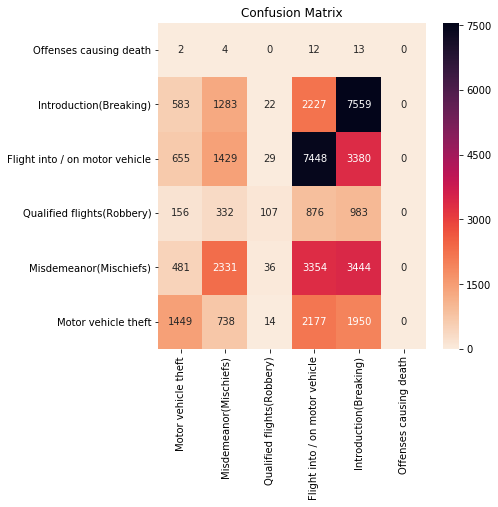

In [12]:
#Results
print("========== Random Forest Results ==========\n")
result(rf_random)

In [24]:
#printing best parameters
print(rf_random.best_params_)

{'n_estimators': 500, 'min_samples_leaf': 3, 'max_features': 2, 'criterion': 'entropy', 'bootstrap': True}


In [13]:
#knn
knn_classifier=KNeighborsClassifier()

#Hyperparameters
params_knn={
    'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn_random = RandomizedSearchCV(estimator = knn_classifier, param_distributions = params_knn, n_iter = 50, cv = 3, 
                               verbose=2, random_state=0, n_jobs = -1)
knn_random.fit(X_train,y_train.values.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 30.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   re

========== KNN Results ==========

Accuracy    :  39.32999024933835
Recall      :  39.32999024933835
Precision   :  38.319904230827795
F1 Score    :  39.32999024933835


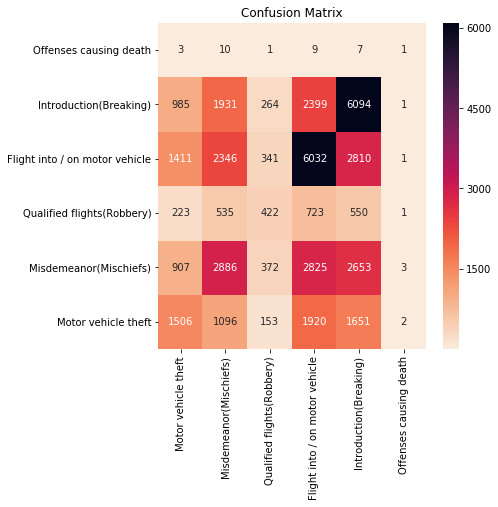

In [14]:
#Results
print("========== KNN Results ==========\n")
result(knn_random)

In [23]:
#printing best parameters
print(knn_random.best_params_)

{'weights': 'distance', 'n_neighbors': 10, 'algorithm': 'auto'}


In [15]:
#AdaBoost
ab_classifier = AdaBoostClassifier()

#Hyperparameters
params_ab={
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)],
    'learning_rate': scipy.stats.reciprocal(0.01, 1.0),
    'algorithm': ['SAMME.R', 'SAMME'],
    'random_state': [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
}

ab_random = RandomizedSearchCV(estimator = ab_classifier, param_distributions = params_ab, n_iter = 50, cv = 3, 
                               verbose=2, random_state=0, n_jobs = -1)
ab_random.fit(X_train,y_train.values.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 41.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME.R', 'SAMME'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161560FC308>,
                                        'n_estimators': [10, 64, 118, 173, 227,
                                                         282, 336, 391, 445,
                                                         500],
                                        'random_state': [1, 2, 3, 4, 5, 6, 7, 8,
                                          

========== Ada Boost Results ==========

Accuracy    :  37.60273018526257
Recall      :  37.60273018526257
Precision   :  33.32040466650246
F1 Score    :  37.60273018526257


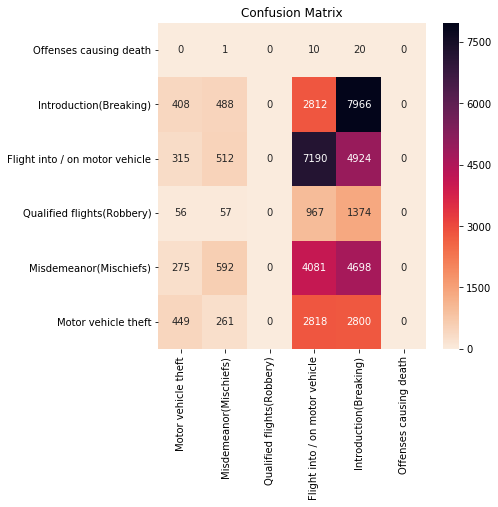

In [16]:
#Results
print("========== Ada Boost Results ==========\n")
result(ab_random)

In [22]:
#printing best parameters
print(ab_random.best_params_)

{'algorithm': 'SAMME', 'learning_rate': 0.12296071107325704, 'n_estimators': 500, 'random_state': 4}
